# How To: Land-Use-Land-Cover Prediction for Slovenia

This notebook shows the steps towards constructing a machine learning pipeline for predicting the land use and land cover for the region of Republic of Slovenia. We will use satellite images obtained by ESA's Sentinel-2 to train a model and use it for prediction. The example will lead you through the whole process of creating the pipeline, with details provided at each step.

## Before you start

### Requirements

In order to run the example you'll need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, login to [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/). By default you will already have the default configuration with an **instance ID** (alpha-numeric code of length 36). For this tutorial we recommend that you create a new configuration (`"Add new configuration"`) and set the configuration to be based on **Python scripts template**. Such configuration will already contain all layers used in these examples. Otherwise you will have to define the layers for your configuration yourself.

After you have prepared a configuration please put configuration's **instance ID** into `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html).

### Overview

#### Part 1:

1. Define the Area-of-Interest (AOI):
   * Obtain the outline of Slovenia (provided)
   * Split into manageable smaller tiles
   * Select a small 3x3 area for classification
2. Use the integrated [sentinelhub-py](https://github.com/sentinel-hub/sentinelhub-py) package in order to fill the EOPatches with some content (band data, cloud masks, ...)
   * Define the time interval (this example uses the whole year of 2017)
3. Add additional information from band combinations (norm. vegetation index - NDVI, norm. water index - NDWI)
4. Add a reference map (provided)
   * Convert provided vector data to raster and add it to EOPatches
   
#### Part 2:

5. Prepare the training data
   * Remove too cloudy scenes
   * Perform temporal interpolation (filling gaps and resampling to the same dates)
   * Apply erosion 
   * Random spatial sampling of the EOPatches
   * Split patches for training/validation
6. Construct and train the ML model
   * Make the prediction for each patch 
7. Validate the model
8. Visualise the results

Let's start!

In [1]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from enum import Enum

# Basics of Python data handling and visualization
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm import tqdm_notebook as tqdm

# Machine learning 
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam



/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Part 1

## 1. Define the Area-of-Interest (AOI):

* A geographical shape of Slovenia was taken from [Natural Earth database](http://www.naturalearthdata.com/downloads/10m-cultural-vectors/) and a buffer was applied. The shape is available in repository: `example_data/svn_buffered.geojson`
* Convert it to selected CRS: taken to be the CRS of central UTM tile (UTM_33N)
* Split it into smaller, manageable, non-overlapping rectangular tiles
* Select a small 3x3 area for classification

Be sure that your choice of CRS is the same as the CRS of your reference data.

In the case that you are having problems with empty data being downloaded, try changing the CRS to something that suits the location of the AOI better.

### Get country boundary

Dimension of the area is 249870 x 171656 m2


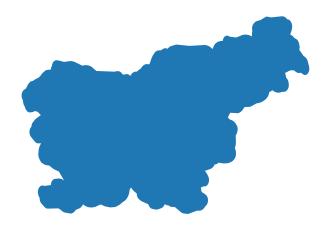

In [2]:
# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join('..', '..', 'example_data')

# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, 'svn_buffered.geojson'))

# Convert CRS to UTM_33N
country_crs = CRS.UTM_33N
country = country.to_crs(crs={'init': CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values.tolist()[-1]

# Plot country
country.plot()
plt.axis('off');

# Print size 
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],
                                                             country_shape.bounds[3] - country_shape.bounds[1]))

### Split to smaller tiles and choose a 3x3 area

The above size of 249870 x 171656 m2 suggests a rough splitting of 25 (columns) x 17 (rows). However, the splitting choice depends on the available resources of your computer, so two options are presented in the following. A 3x3 EOPatch sample, where each EOPatch has around 1000 x 1000 pixels at 10 meter resolution (~3 GB per EOPatch), or a sample with about 330 x 330 pixels at 10 meter resolution (~300 MB per EOPatch).

Two options are available, so make a choice.

In [3]:
use_smaller_patches = True

# Create the splitter to obtain a list of bboxes
bbox_splitter_large = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_splitter_small = BBoxSplitter([country_shape], country_crs, (25 * 3, 17 * 3))

bbox_splitter = bbox_splitter_small if use_smaller_patches else bbox_splitter_large

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# For the future examples, we will be using a specific set of patches,
# but you are free to change the patch ID numbers in the scope of this example
# Select a central patch
ID = 1549 if use_smaller_patches else 190 

# Obtain surrounding patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 9:
    print('Warning! Use a different central patch ID, this one is on the border.')
    
# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()
    
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]

gdf = gpd.GeoDataFrame({'index_x': idxs_x, 'index_y': idxs_y}, 
                       crs={'init': CRS.ogc_string(country_crs)}, 
                       geometry=geometry)

# save to shapefile
shapefile_name = './selected_3x3_bboxes_slovenia_small.shp' if use_smaller_patches \
    else './selected_3x3_bboxes_slovenia_large.shp'
gdf.to_file(shapefile_name)

### Visualize the selection

In [4]:
poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

# content of the geopandas dataframe
gdf.head()

,index_x,index_y,geometry
0,42,29,"POLYGON ((510157.6172221425 5122327.229129893,..."
1,43,29,"POLYGON ((513489.214628833 5122327.229129893, ..."
2,44,29,"POLYGON ((516820.8120355235 5122327.229129893,..."
3,42,28,"POLYGON ((510157.6172221425 5118961.421479214,..."
4,43,28,"POLYGON ((513489.214628833 5118961.421479214, ..."


(357737.03586605104, 632593.8219180192, 5016135.9977509845, 5204957.80695405)

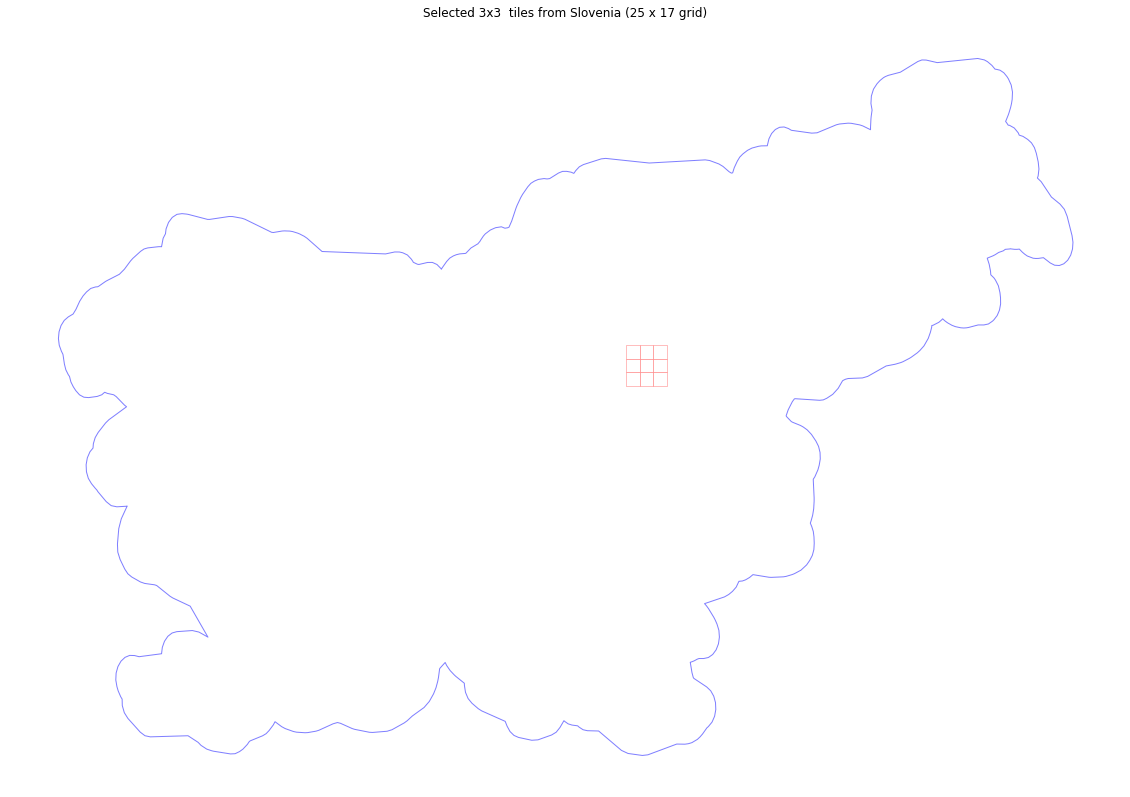

In [5]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3  tiles from Slovenia (25 x 17 grid)');
plt.axis('off')

## 2. - 4. Fill EOPatches with data:

Now it's time to create EOPatches and fill them with Sentinel-2 data using Sentinel Hub services. We will add the following data to each EOPatch:

* L1C custom list of bands [B02, B03, B04, B08, B11, B12], which corresponds to [B, G, R, NIR, SWIR1, SWIR2] wavelengths.

* SentinelHub's cloud probability map and cloud mask

Additionally, we will add:

* Calculated NDVI, NDWI, euclidean NORM information

* A mask of validity, based on acquired data from Sentinel and cloud coverage. Valid pixel is if:
   
    1. IS_DATA == True
    2. CLOUD_MASK == 0 (1 indicates that pixel was identified to be covered with cloud)

An EOPatch is created and manipulated using EOTasks, which are chained in an EOWorkflow. In this example the final workflow is executed on all patches, which are saved to the specified directory.

### Define some needed custom EOTasks

In [6]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
    
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch


class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndi = (band_a - band_b) / (band_a  + band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])
        
        return eopatch

    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch

### Define the workflow tasks

In [7]:
# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12) 
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover 
# detection is performed in the next step
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C', 
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution 
# and the resulting cloud probability map and mask 
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m', 
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask 
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

#### Reference map task

For this example, a subset of the country-wide reference for land-use-land-cover is provided. It is available in the form of a shapefile, which contains polygons and their corresponding labels. The labels represent the following 10 classes:

* lulcid = 0, name = no data
* lulcid = 1, name = cultivated land
* lulcid = 2, name = forest
* lulcid = 3, name = grassland
* lulcid = 4, name = shrubland
* lulcid = 5, name = water
* lulcid = 6, name = wetlands
* lulcid = 7, name = tundra
* lulcid = 8, name = artificial surface
* lulcid = 9, name = bareland
* lulcid = 10, name = snow and ice

We have defined a land cover class for ease of use below

In [8]:
class LULC(Enum):
    NO_DATA            = (0,  'No Data',            'white')
    CULTIVATED_LAND    = (1,  'Cultivated Land',    'xkcd:lime')
    FOREST             = (2,  'Forest',             'xkcd:darkgreen')
    GRASSLAND          = (3,  'Grassland',          'orange')
    SHRUBLAND          = (4,  'Shrubland',          'xkcd:tan')
    WATER              = (5,  'Water',              'xkcd:azure')
    WETLAND            = (6,  'Wetlands',           'xkcd:lightblue')
    TUNDRA             = (7,  'Tundra',             'xkcd:lavender')
    ARTIFICIAL_SURFACE = (8,  'Artificial Surface', 'crimson')
    BARELAND           = (9,  'Bareland',           'xkcd:beige')
    SNOW_AND_ICE       = (10, 'Snow and Ice',       'black')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3
        
# example usecase
# LULC.BARELAND.id   # return 9
        
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)

The main point of this task is to create a raster mask from the vector polygons and add it to the eopatch. With this procedure, any kind of a labeled shapefile can be transformed into a raster reference map. This result is achieved with the existing task `VectorToRaster` from the `eolearn.geometry` package. All polygons belonging to the each of the classes are separately burned to the raster mask.

Land use data are public in Slovenia, you can download the full dataset [here](http://rkg.gov.si/GERK/), selecting the `Grafični podatki RABA za celo Slovenijo (shape.rar ~ 500 MB) KoordSistem: D96/TM`. The dataset is provided in the national `D96/TM` coordinate system. In order to use this dataset, you have to first convert the CRS to `UTM_33N`!

The provided dataset in this notebook has already been converted for the purposes of the example.

In [ ]:
name_str = 'small' if use_smaller_patches else 'large'
land_cover_path = os.path.join(DATA_FOLDER, 'land_cover_subset_{}'.format(name_str),
                               'land_cover_subset_{}.shp'.format(name_str))

land_cover_data = gpd.read_file(land_cover_path)

rasterization_task = VectorToRaster(land_cover_data, (FeatureType.MASK_TIMELESS, 'LULC'),
                                    values_column='lulcid', raster_shape=(FeatureType.MASK, 'IS_VALID'),
                                    raster_dtype=np.uint8)

### Define the workflow

All the tasks that were defined so far create and fill the EOPatches. The tasks need to be put in some order and executed one by one. This can be achieved by manually executing the tasks, or more conveniently, defining an `EOWorkflow` which does this for you.

The following workflow is created and executed:

1. Create EOPatches with band data
2. Add cloud info
3. Calculate and add NDVI, NDWI, NORM
4. Add mask of valid pixels
5. Add scalar feature representing the cound of valid pixels
7. Save eopatches

An EOWorkflow can be linear or more complex, but it should be acyclic. Here we will use the linear case of the EOWorkflow, available as `LinearWorkflow`

Define the workflow

In [ ]:
# Define the workflow
workflow = LinearWorkflow(
    add_data,
#     add_clm,
#     ndvi,
#     ndwi,
#     norm,
#     add_sh_valmask,
#     count_val_sh,
#     rasterization_task,
    save
)

# Let's visualize it
workflow.dependency_graph()

_This may take some time, so go grab a cup of coffee ..._

In [ ]:
%%time

# Execute the workflow
time_interval = ['2017-01-01', '2017-12-31'] # time interval for the SH request

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    });
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=False)

executor.make_report()

In [ ]:
plt.imshow(patch.data['BANDS'][0,:,:,1].clip(0,0.4))

In [ ]:
patch = EOPatch.load('./eopatches_small/eopatch_0/')
patch

### Visualize the patches

Let's load a single **small** EOPatch and look at the structure. By executing 
```
EOPatch.load('./eopatches_small/eopatch_0/')
```

We obtain the following structure:

```
EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(69, 337, 333, 6), dtype=float32)
    CLP: numpy.ndarray(shape=(69, 337, 333, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(69, 337, 333, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(69, 337, 333, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(69, 337, 333, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(69, 337, 333, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(69, 337, 333, 1), dtype=uint8)
    IS_VALID: numpy.ndarray(shape=(69, 337, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: numpy.ndarray(shape=(337, 333, 1), dtype=uint8)
    VALID_COUNT: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(-1, 86399)
    time_interval: <class 'list'>, length=2
  }
  bbox: BBox(((510157.61722214246, 5122327.229129893), (513489.214628833, 5125693.036780571)), crs=EPSG:32633)
  timestamp: <class 'list'>, length=69
)
```

It is possible to then access various EOPatch content via calls like:
```
eopatch.timestamp
eopatch.mask['LULC']
eopatch.data['NDVI'][0]
eopatch.data['BANDS'][5][..., [3, 2, 1]]

```

In this case, all patches come from a small region, so all of them have the same dates of acquisition for at least a few dates, so we can inspect the area without interpolation at this point.

In [ ]:
# Draw the RGB image
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
fig = plt.figure(figsize=(20, 20 * aspect_ratio))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.clip(eopatch.data['BANDS'][0][..., [2, 1, 0]] * 3.5, 0, 1))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

### Visualize the reference map

In [ ]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)

pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    im = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15)
plt.show()

### Plot the map of valid pixel counts

In [ ]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

vmin, vmax = None, None
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    data = eopatch.mask_timeless['VALID_COUNT'].squeeze()
    vmin = np.min(data) if vmin is None else (np.min(data) if np.min(data) < vmin else vmin)
    vmax = np.max(data) if vmax is None else (np.max(data) if np.max(data) > vmax else vmax)

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)
    
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    im = ax.imshow(eopatch.mask_timeless['VALID_COUNT'].squeeze(), vmin=vmin, vmax=vmax, cmap=plt.cm.inferno)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

### Spatial mean of NDVI

Plot the mean of NDVI over all pixels in a single patch throughout the year. Filter out clouds in the mean calculation.

In [ ]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

eID = 1
eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, eID), lazy_loading=True)

ndvi = eopatch.data['NDVI'] # ndvi data cube
mask = eopatch.mask['IS_VALID'] # mask of valid pixels
time = np.array(eopatch.timestamp) # x axis
t, w, h, _ = ndvi.shape 

ndvi_clean = ndvi.copy()
ndvi_clean[~mask] = np.nan # set values of invalid pixels to NaN's

# Calculate means, remove NaN's from means
ndvi_mean = np.nanmean(ndvi.reshape(t, w * h).squeeze(), axis=1) 
ndvi_mean_clean = np.nanmean(ndvi_clean.reshape(t, w * h).squeeze(), axis=1)
time_clean = time[~np.isnan(ndvi_mean_clean)]
ndvi_mean_clean = ndvi_mean_clean[~np.isnan(ndvi_mean_clean)]

fig = plt.figure(figsize=(20,5))
plt.plot(time_clean, ndvi_mean_clean, 's-', label = 'Mean NDVI with cloud cleaning')
plt.plot(time, ndvi_mean, 'o-', label='Mean NDVI without cloud cleaning')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Mean NDVI over patch', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc=2, prop={'size': 15});

### Temporal mean of NDVI

Plot the time-wise mean of NDVI for the whole region. Filter out clouds in the mean calculation.

In [ ]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)
    
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    ndvi = eopatch.data['NDVI']
    mask = eopatch.mask['IS_VALID']
    ndvi[~mask] = np.nan
    ndvi_mean = np.nanmean(ndvi, axis=0).squeeze()
    im = ax.imshow(ndvi_mean, vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

### Plot the average cloud probability

Plot te average of the cloud probability for each pixel, take the cloud mask into account.

Some structures can be seen like road networks etc., indicating a bias of the cloud detector towards these objects.

In [ ]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)
    
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    clp = eopatch.data['CLP']
    mask = eopatch.mask['IS_VALID']
    clp[~mask] = np.nan
    clp_mean = np.nanmean(clp, axis=0).squeeze()
    im = ax.imshow(clp_mean, vmin=0.0, vmax=0.3, cmap=plt.cm.inferno)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

# Part 2

## 5. Prepare the training data

We will create a new workflow that processes the data:

1. Remove too cloudy scenes
   * Check the ratio of the valid data for each patch and for each time frame
   * Keep only time frames with > 80 % valid coverage (no clouds)
2. Concatenate BAND, NDVI, NDWI, NORM info into a single feature called FEATURES
3. Perform temporal interpolation (filling gaps and resampling to the same dates)
   * Create a task for linear interpolation in the temporal dimension
   * Provide the cloud mask to tell the interpolating function which values to update
4. Perform erosion
   * This removes artefacts with a width of 1 px, and also removes the edges between polygons of different classes
5. Random spatial sampling of the EOPatches
   * Randomly take a subset of pixels from a patch to use in the machine learning training
6. Split patches for training/validation
   * Split the patches into a training and validation set

### Define EOTasks

In [ ]:
class ConcatenateData(EOTask):
    """ Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch
    
    
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

In [ ]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out)

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ('2017-01-01', '2017-12-31', 16)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, 'LULC')], # features to keep
    resample_range=resampled_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)

# TASK FOR EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LULC','LULC_ERODED'), disk_radius=1)

# TASK FOR SPATIAL SAMPLING
# Uniformly sample about pixels from patches
n_samples = int(4e4) if use_smaller_patches else int(1e5) # no. of pixels to sample
ref_labels = list(range(11)) # reference labels to take into account when sampling
spatial_sampling = PointSamplingTask(
    n_samples=n_samples, 
    ref_mask_feature='LULC_ERODED', 
    ref_labels=ref_labels, 
    sample_features=[  # tag fields to sample
        (FeatureType.DATA, 'FEATURES'),
        (FeatureType.MASK_TIMELESS, 'LULC_ERODED')
    ])

path_out_sampled = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'
if not os.path.isdir(path_out_sampled):
    os.makedirs(path_out_sampled)
save = SaveToDisk(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [ ]:
# Define the workflow
workflow = LinearWorkflow(
    load,
    concatenate,
    filter_task,
    linear_interp,
    erosion,
    spatial_sampling,
    save
)

### Run the EOWorkflow over all EOPatches

In [ ]:
%%time
   
execution_args = []
for idx in range(len(patchIDs)):
    execution_args.append({
        load: {'eopatch_folder': 'eopatch_{}'.format(idx)},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=True)

executor.make_report()

## 6. Model construction and training

The patches are split into a train and test subset, where we take the patch with ID = 1 for testing, since it seems a good representative of the area. 

The test sample is hand picked because of the small set of patches, otherwise with a larged overall set, the training and testing patches should be randomly chosen.

The sampled features and labels are loaded and reshaped into $n \times m$, where $n$ represents the number of training pixels, and $m = f \times t$ the number of all features (in this example 207), with $f$ the size of bands and band combinations (in this example 9) and $t$ the length of the resampled time-series (in this example 23)

[LightGBM](https://github.com/Microsoft/LightGBM) is used as a ML model. It is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms, used for many machine learning tasks.

The default hyper-parameters are used in this example. For more info on parameter tuning, check the [ReadTheDocs](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) of the package.

In [ ]:
# load sampled eopatches
eopatches = []
path_out_sampled = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'

for i in range(9):
    eopatches.append(EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, i), lazy_loading=True))    

eopatches = np.array(eopatches)

In [ ]:
# Definition of the train and test patch IDs
train_ID = [0,2,3,4,5,6,7,8] if use_smaller_patches else [0,1,3,4,5,6,7,8]
test_ID = [1] if use_smaller_patches else [2]

# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[train_ID]])
labels_train = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[train_ID]])
features_test = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[test_ID]])
labels_test = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[test_ID]])

# get shape
p1, t, w, h, f = features_train.shape
p2, t, w, h, f = features_test.shape
p = p1 + p2

# reshape to n x m
features_train = np.moveaxis(features_train, 1, 3).reshape(p1 * w * h, t * f)
labels_train = np.moveaxis(labels_train, 1, 2).reshape(p1 * w * h, 1).squeeze()
features_test = np.moveaxis(features_test, 1, 3).reshape(p2 * w * h, t * f)
labels_test = np.moveaxis(labels_test, 1, 2).reshape(p2 * w * h, 1).squeeze()

# remove points with no reference from training (so we dont train to recognize "no data")
mask_train = labels_train == 0
features_train = features_train[~mask_train]
labels_train = labels_train[~mask_train]

# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
mask_test = labels_test == 0
features_test = features_test[~mask_test]
labels_test = labels_test[~mask_test]

### Set up and train the model

In [ ]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective='multiclass', 
    num_class=len(labels_unique), 
    metric='multi_logloss'
) 

# train the model
model.fit(features_train, labels_train)

# uncomment to save the model
model_base_name = 'model_SI_LULC_smaller' if use_smaller_patches else 'model_SI_LULC_larger'
joblib.dump(model, './{}.pkl'.format(model_base_name))

## 7. Validation

Validation of the model is a crucial step in data science. All models are wrong, but some are less wrong than others, so model evaluation is important.

In order to validate the model, we use the training set to predict the classes, and then compare the predicted set of labels to the "ground truth".

Unfortunately, ground truth in the scope of EO is a term that should be taken lightly. Usually, it is not 100 % reliable due to several reasons:

* Labels are determined at specific time, but land use can change (_what was once a field, may now be a house_)
* Labels are overly generalized (_a city is an artificial surface, but it also contains parks, forests etc._)
* Some classes can have an overlap or similar definitions (_part of a continuum, and not discrete distributions_)
* Human error (_mistakes made when producing the reference map_)

The validation is performed by evaluating various metrics, such as accuracy, precision, recall, $F_1$ score, some of which are nicely described [in this blog post](https://medium.com/greyatom/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b)

In [ ]:
# uncomment to load the model and replace with your file, usually just correct the date
model_path = './model_SI_LULC_smaller.pkl' if use_smaller_patches else './model_SI_LULC_larger.pkl'
model = joblib.load(model_path)

# predict the test labels
plabels_test = model.predict(features_test)

Get the overall accuracy (OA) and the weighted $F_1$ score

In [ ]:
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_test, plabels_test)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_test, plabels_test, average='weighted')))

$F_1$ score, precision, and recall for each class separately

In [ ]:
class_labels = np.unique(labels_test)
class_names = [entry.class_name for entry in LULC]

f1_scores = metrics.f1_score(labels_test, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test, plabels_test, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

### Plot the standard and transposed Confusion Matrix

In [ ]:
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

In [ ]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
conf_matrix_gbm = metrics.confusion_matrix(labels_test, plabels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Truth (LAND COVER)', 
                      xlabel='Predicted (GBM)',
                      title='Confusion matrix');

plt.subplot(1, 2, 2)
conf_matrix_gbm = metrics.confusion_matrix(plabels_test, labels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      xlabel='Truth (LAND COVER)', 
                      ylabel='Predicted (GBM)',
                      title='Transposed Confusion matrix');

plt.tight_layout()

For most of the classes the model seems to perform well. Otherwise the training sample is probably too small to make a fair assesment. 
Additional problems arise due to the unbalanced training set. The image below shows the frequency of the classes used for model training, and we see that the problematic cases are all the under-represented classes: shrubland, water, wetland, and bareland. 

Improving the reference map would also affect the end result, as, for example some classes are mixed up to some level.

In [ ]:
fig = plt.figure(figsize=(20, 5))

label_ids, label_counts = np.unique(labels_train, return_counts=True)

plt.bar(range(len(label_ids)), label_counts)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation=45, fontsize=20);
plt.yticks(fontsize=20);

### ROC curves and AUC metrics

Calculate precision and recall rates, draw ROC curves and calculate AUC.

In [ ]:
class_labels = np.unique(np.hstack([labels_test, labels_train]))

scores_test = model.predict_proba(features_test)
labels_binarized = preprocessing.label_binarize(labels_test, classes=class_labels)

fpr = dict()
tpr = dict()
roc_auc = dict()

for idx,lbl in enumerate(class_labels):
    fpr[idx], tpr[idx], _ = metrics.roc_curve(labels_binarized[:, idx], scores_test[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx])    

In [ ]:
plt.figure(figsize=(20, 10))

for idx,lbl in enumerate(class_labels):
    if np.isnan(roc_auc[idx]):
        continue
    plt.plot(fpr[idx], tpr[idx], color=lulc_cmap.colors[lbl],
         lw=2, label=class_names[lbl] + ' (%0.5f)' % roc_auc[idx])
    

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.99])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('ROC Curve', fontsize=20)
plt.legend(loc="center right", prop={'size': 15})
plt.show()

### Most important features

Let us now check which features are most important in the above classification. The LightGBM model already contains the information about feature importances, so we only need to query them. 

In [ ]:
# names of features
fnames = ['B2','B3','B4','B8','B11','B12','NDVI','NDWI','NORM']

# get feature importances and reshape them to dates and features
z = model.feature_importances_.reshape((t, f))

fig = plt.figure(figsize=(15, 15))
ax = plt.gca()

# plot the importances
im = ax.imshow(z, aspect=0.25)
plt.xticks(range(len(fnames)), fnames, rotation=45, fontsize=20)
plt.yticks(range(t), ['T{}'.format(i) for i in range(t)], fontsize=20)
plt.xlabel('Bands and band related features', fontsize=20)
plt.ylabel('Time frames', fontsize=20)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# cax = fig.add_axes([0.82, 0.125, 0.04, 0.755]) 
# plt.colorbar(im, cax=cax)

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=[ax], orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 

We see that the most important features are from time frame `T1` (in this case `B2` and `NDVI`). If we look at the image for that time, we see that it is covered in snow, as shown below. It seems that snow cover provides useful information for land-use-land-cover classification.

In [ ]:
# Draw the RGB image
path_out_sampled = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'
fig = plt.figure(figsize=(20, 20 * aspect_ratio))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, i), lazy_loading=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.clip(eopatch.data['FEATURES'][1][..., [2, 1, 0]] * 2.5, 0, 1))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

We can also check by comparing histograms for each class for `B2` and for `NDVI` on different dates. Left are the histograms for the date `T1` and for `T19` on the right. We see that for the optimal time `T1`, the feature distributions are more separatable then on a non-optimal time, so snow cover really does seem to help.

In [ ]:
b2_t1 = np.moveaxis(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches]),
                    1, 3)[..., 1, 0].reshape(p * h * w)
b2_t19 = np.moveaxis(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches]),
                     1, 3)[..., 19, 0].reshape(p * h * w)
ndvi_t1 = np.moveaxis(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches]),
                      1, 3)[..., 1, 6].reshape(p * h * w)
ndvi_t19 = np.moveaxis(np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches]),
                       1, 3)[..., 19, 6].reshape(p * h * w)
labels = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches]).reshape(p * h * w * 1)

# remove nans
mask = np.any([np.isnan(b2_t1), np.isnan(b2_t19), np.isnan(ndvi_t1), np.isnan(ndvi_t19), labels==0], axis=0)
b2_t1, b2_t19, ndvi_t1, ndvi_t19, labels = [array[~mask] for array in [b2_t1, b2_t19, ndvi_t1, ndvi_t19, labels]]

In [ ]:
fig = plt.figure(figsize=(20, 20))

plot_labels = np.unique(labels)
plot_colors = lulc_cmap.colors

plt.subplot(2, 2, 1)
plt.hist([b2_t1[labels == i] for i in np.unique(labels)], 100, (0.1, 0.7),histtype='step', 
         color=[plot_colors[i] for i in plot_labels]);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('B2', fontsize=20)
plt.title('Optimal time', fontsize=20)


plt.subplot(2, 2, 2)
plt.hist([b2_t19[labels == i] for i in np.unique(labels)],100,(0.1, 0.7),histtype='step', 
         color=[plot_colors[i] for i in plot_labels]);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('B2', fontsize=20);
plt.title('Non-optimal time', fontsize=20)


plt.subplot(2, 2, 3)
plt.hist([ndvi_t1[labels == i] for i in plot_labels],100,(-0.4, 0.8),histtype='step', 
         color=[plot_colors[i] for i in plot_labels],
         label=[class_names[i] for i in plot_labels]);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('NDVI', fontsize=20)
plt.legend(loc=1, prop={'size': 15})

plt.subplot(2, 2, 4)
plt.hist([ndvi_t19[labels == i] for i in np.unique(labels)],100,(-0.4, 0.8),histtype='step', 
         color=[plot_colors[i] for i in plot_labels]);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('NDVI', fontsize=20);

## 8. Visualization of the results

The model has been validated, the remaining thing is to make the prediction on the whole AOI.

Here we define a workflow to make the model prediction on the existing EOPatces. The EOTask accepts the features and the names for the labels and scores. The latter is optional.

### Define EOTasks

In [ ]:
class PredictPatch(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature, 
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name
        
    def execute(self, eopatch):
        ftrs = eopatch[self.features_feature[0]][self.features_feature[1]]
        
        t, w, h, f = ftrs.shape
        ftrs = np.moveaxis(ftrs, 0, 2).reshape(w * h, t * f)
        
        plabels = self.model.predict(ftrs)
        plabels = plabels.reshape(w, h)
        plabels = plabels[..., np.newaxis]
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.predicted_labels_name, plabels)
        
        if self.predicted_scores_name:
            pscores = self.model.predict_proba(ftrs)
            _, d = pscores.shape
            pscores = pscores.reshape(w, h, d)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.predicted_scores_name, pscores)
        
        return eopatch

### Define Tasks and the Workflow

In [ ]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out_sampled)

# TASK FOR PREDICTION
predict = PredictPatch(model, (FeatureType.DATA, 'FEATURES'), 'LBL_GBM', 'SCR_GBM')

# TASK FOR SAVING
save = SaveToDisk(str(path_out_sampled), overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# TASK TO EXPORT TIFF
export_tiff = ExportToTiff((FeatureType.MASK_TIMELESS, 'LBL_GBM'))
tiff_location = './predicted_tiff'
if not os.path.isdir(tiff_location):
    os.makedirs(tiff_location)

workflow = LinearWorkflow(
    load,
    predict,
    export_tiff,
    save
)

### Run the prediction and export to GeoTIFF images

Here we use the `EOExecutor` to run the workflow in parallel.

In [ ]:
# create a list of execution arguments for each patch
execution_args = []
for i in range(len(patchIDs)):
    execution_args.append(
        {
            load: {'eopatch_folder': 'eopatch_{}'.format(i)},
            export_tiff: {'filename': '{}/prediction_eopatch_{}.tiff'.format(tiff_location, i)},
            save: {'eopatch_folder': 'eopatch_{}'.format(i)}
        }
    )

# run the executor on 2 cores
executor = EOExecutor(workflow, execution_args)

# uncomment below save the logs in the current directory and produce a report!
#executor = EOExecutor(workflow, execution_args, save_logs=True)

executor.run(workers=2, multiprocess=False)
executor.make_report()

In [ ]:
%%time
# merge with gdal_merge.py (with compression) using bash command magic
!gdal_merge.py -o predicted_tiff/merged_prediction.tiff -co compress=LZW predicted_tiff/prediction_eopatch_*

### Visualise the prediction

In [ ]:
path_out_sampled = './eopatches_sampled_small/' if use_smaller_patches else './eopatches_sampled_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)

pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, i), lazy_loading=True)
    im = ax.imshow(eopatch.mask_timeless['LBL_GBM'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15)
plt.show()

### Visual inspection of patches

Here is just a simple piece of code that allows a closer inspection of the predicted labels. 

Random subsets of patches are chosen, where prediction and ground truth are compared. For visual aid the mask of differences and the true color image are also provided.

In majority of the cases, differences seem to lie on the border of different structures.

In [ ]:
# Draw the Reference map

fig = plt.figure(figsize=(20, 20))

idx = np.random.choice(range(9))
inspect_size = 100

eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, idx), lazy_loading=True)

w, h = eopatch.mask_timeless['LULC'].squeeze().shape

w_min = np.random.choice(range(w - inspect_size))
h_min = np.random.choice(range(h - inspect_size))

ax = plt.subplot(2, 2, 1)
plt.imshow(eopatch.mask_timeless['LULC'].squeeze()[w_min: w_min + inspect_size, h_min : h_min + inspect_size],
           cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Ground Truth', fontsize=20)

ax = plt.subplot(2, 2, 2)
plt.imshow(eopatch.mask_timeless['LBL_GBM'].squeeze()[w_min: w_min + inspect_size, h_min: h_min + inspect_size],
           cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Prediction', fontsize=20)

ax = plt.subplot(2, 2, 3)
mask = eopatch.mask_timeless['LBL_GBM'].squeeze() != eopatch.mask_timeless['LULC'].squeeze()
plt.imshow(mask[w_min: w_min + inspect_size, h_min: h_min + inspect_size], cmap='gray')
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('Difference', fontsize=20)

ax = plt.subplot(2, 2, 4)
image = np.clip(eopatch.data['FEATURES'][8][..., [2, 1, 0]] * 3.5, 0, 1)
plt.imshow(image[w_min: w_min + inspect_size, h_min: h_min + inspect_size])
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('True Color', fontsize=20)

fig.subplots_adjust(wspace=0.1, hspace=0.1)